# Azure Machine Learning - AutoML Experiment using v2 SDK

Sample here can be run from an Azure ML Compute Instance using the Python 3.10 - SDK v2 Kernel

### Import required packages

In [1]:
# Import necessary packages and modules  
from azure.ai.ml import MLClient, Input, automl
from azure.ai.ml.entities import Data, AmlCompute, Model, ModelPackage, CodeConfiguration, AzureMLOnlineInferencingServer, ManagedOnlineEndpoint, ManagedOnlineDeployment, Environment
from azure.ai.ml.constants import AssetTypes  
from azure.ai.ml import automl
from azure.identity import DefaultAzureCredential  
import mltable  
import pandas as pd    
import numpy as np    
import random

### Instantiate ml_client

In [2]:
# Create MLClient object from configuration file and DefaultAzureCredential  
ml_client = MLClient.from_config(credential=DefaultAzureCredential())  

# Print the MLClient object  
print(ml_client)  

Found the config file in: /config.json


MLClient(credential=<azure.identity._credentials.default.DefaultAzureCredential object at 0x769c47ffd270>,
         subscription_id=28d2df62-e322-4b25-b581-c43b94bd2607,
         resource_group_name=uhg-rx-owca,
         workspace_name=uhg-rx-aml)


### Create compute cluster for AutoML training

In [3]:
# Define the name of the CPU compute target to be used or created  
cpu_compute_target = "cpu-cluster"  
  
try:  
    # Try to get the details of the specified compute target if it already exists  
    ml_client.compute.get(cpu_compute_target)  
except Exception:  
    # If the compute target does not exist, catch the exception and create a new one  
    print("Creating a new cpu compute target...")  
    # Define the compute target specifications such as name, VM size, and instance limits  
    compute = AmlCompute(  
        name=cpu_compute_target, size="STANDARD_D2_V2", min_instances=0, max_instances=4  
    )  
    # Initiate the creation or update of the compute target and wait for the operation to complete  
    ml_client.compute.begin_create_or_update(compute).result() 

### Split data into train/validation/test subsets

Split by 60/20/20 or you can change. Be sure to use stratification to keep representative samples of your population.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

# ─── Configuration ──────────────────────────────────────────────────────────
input_path   = 'claims/claims_short.csv'
output_dir   = 'claims/claims_short'
target_col   = 'long_term_3y'

# ratios must sum to 1.0
train_ratio  = 0.6
test_ratio   = 0.2
validate_ratio = 0.2

random_state = 42  # for reproducibility
# ─── End configuration ──────────────────────────────────────────────────────

In [5]:
# 0) Create directory
def ensure_dir(directory: str):
    """
    Create `directory` (and any parents) if it doesn't already exist.
    """
    os.makedirs(directory+'/train', exist_ok=True)
    os.makedirs(directory+'/test', exist_ok=True)
    os.makedirs(directory+'/validate', exist_ok=True)
ensure_dir(output_dir)

# 1) Load the full dataset
df = pd.read_csv(input_path)

# 2) First split off training set
temp_ratio = test_ratio + validate_ratio
df_train, df_temp = train_test_split(
    df,
    test_size=temp_ratio,
    random_state=random_state,
    shuffle=True,
    stratify=df[target_col]  # uncomment to preserve class balance
)

# 3) Split the remainder into test + validate
#    Compute test size as a fraction of the "temp" set
test_frac_of_temp = test_ratio / temp_ratio

df_test, df_validate = train_test_split(
    df_temp,
    test_size=test_frac_of_temp,
    random_state=random_state,
    shuffle=True,
    # stratify=df_temp[target_col]
)

# 4) Save to CSV (headers preserved, no extra index column)
df_train.to_csv(f'{output_dir}/train/train.csv',     index=False)
df_test.to_csv( f'{output_dir}/test/test.csv',      index=False)
df_validate.to_csv(f'{output_dir}/validate/validate.csv', index=False)

print(f'Train: {len(df_train)} rows')
print(f'Test:  {len(df_test)} rows')
print(f'Validate: {len(df_validate)} rows')

Train: 316 rows
Test:  105 rows
Validate: 106 rows


In [6]:
def register_mltable_dataset(
    ml_client: MLClient,
    *,
    name: str,
    description: str,
    local_dir: str,
    csv_paths: list[str]
):
    """
    Reads one or more CSVs into an MLTable, saves locally, then
    registers (or updates) it in your Azure ML workspace.

    Returns the full Data asset (with version etc).
    """

    # 1) build and save the MLTable definition
    paths_spec = [{"file": p} for p in csv_paths]
    tbl = mltable.from_delimited_files(paths=paths_spec)
    tbl.save(local_dir)

    # 2) create or update the Data asset
    data_asset = Data(
        path=local_dir,
        type=AssetTypes.MLTABLE,
        description=description,
        name=name,
    )
    registered = ml_client.data.create_or_update(data_asset)

    # 3) fetch full metadata (including version)
    return ml_client.data.get(name=name, version=registered.version)

### Register datasets into the Azure ML workspace for use in model training

In [7]:
# ─── Define your split metadata ────────────────────────────────────────────────
train_name        = "TRAIN_ClaimsOWCA"
train_description = "Training split for claims"
train_dir         = "./claims/claims_short/train"

test_name         = "TEST_ClaimsOWCA"
test_description  = "Test split for claims"
test_dir         = "./claims/claims_short/test"

validate_name        = "VALIDATE_ClaimsOWCA"
validate_description = "Validation split for claims"
validate_dir         = "./claims/claims_short/validate"
# ─── End metadata ───────────────────────────────────────────────────────────────

# Now use those when you register each MLTable
train_asset = register_mltable_dataset(
    ml_client,
    name=train_name,
    description=train_description,
    local_dir=f"{train_dir}",
    csv_paths=[f"{train_dir}/train.csv"],
)

test_asset = register_mltable_dataset(
    ml_client,
    name=test_name,
    description=test_description,
    local_dir=f"{test_dir}",
    csv_paths=[f"{test_dir}/test.csv"],
)

validation_asset = register_mltable_dataset(
    ml_client,
    name=validate_name,
    description=validate_description,
    local_dir=f"{validate_dir}/validate",
    csv_paths=[f"{validate_dir}/validate.csv"],
)

In [8]:
validation_asset

Data({'path': 'azureml://subscriptions/28d2df62-e322-4b25-b581-c43b94bd2607/resourcegroups/uhg-rx-owca/workspaces/uhg-rx-aml/datastores/workspaceblobstore/paths/LocalUpload/81be9d122e795c49322379f2fc200604/validate/', 'skip_validation': False, 'mltable_schema_url': None, 'referenced_uris': ['../validate.csv'], 'type': 'mltable', 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'VALIDATE_ClaimsOWCA', 'description': 'Validation split for claims', 'tags': {}, 'properties': {}, 'print_as_yaml': False, 'id': '/subscriptions/28d2df62-e322-4b25-b581-c43b94bd2607/resourceGroups/uhg-rx-owca/providers/Microsoft.MachineLearningServices/workspaces/uhg-rx-aml/data/VALIDATE_ClaimsOWCA/versions/8', 'Resource__source_path': '', 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/marcjimenez-ci/code/Users/marcjimenez', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x769c014aea40>, 'serialize': <msrest.serialization.Seri

In [9]:
# Define the input data for the training job using the Azure ML dataset identifier for the training dataset  
training_input = Input(path=f'azureml:{train_name}:{train_asset.version}')  
  
# Define the input data for the validation during training using the Azure ML dataset identifier for the validation dataset  
test_input = Input(path=f'azureml:{test_name}:{test_asset.version}')  

# Define the input data for the validation during training using the Azure ML dataset identifier for the validation dataset  
validation_input = Input(path=f'azureml:{validate_name}:{validation_asset.version}')  


### Set up and run an AutoML job

Update the AutoML task as you see fit, add more models, add more CVs, etc.

In [10]:
experiment_name = "claims-long-term-3y-classifier"
max_trials       = 4 #increase this to harden the number of trials per models

# Create the AutoML classification job
# AutoML metrics: https://learn.microsoft.com/en-us/azure/machine-learning/how-to-understand-automated-ml?view=azureml-api-2#classification-metrics
classification_job = automl.classification(
    experiment_name=experiment_name,
    compute=cpu_compute_target,
    training_data=training_input,  
    test_data=test_input,
    target_column_name="long_term_3y",
    primary_metric="AUC_weighted", #https://learn.microsoft.com/en-us/azure/machine-learning/how-to-configure-auto-train?view=azureml-api-2&tabs=python#metrics-for-classification-multi-class-scenarios
    positive_label="1",
    n_cross_validations=5,
    enable_model_explainability=True,
    tags={"dataset": "claims", "task": "long_term_3y"},
)

# Set limits for the AutoML run
classification_job.set_limits(
    timeout_minutes=60,
    trial_timeout_minutes=10,
    max_trials=max_trials,
    enable_early_termination=True,
)

classification_job.set_training(
    allowed_training_algorithms=["XGBoostClassifier"],
)

classification_job.set_featurization(  
    mode='auto'  
) 

In [11]:
# Submit the configured AutoML job to the Azure ML workspace and print the job details  
returned_job = ml_client.jobs.create_or_update(  
    classification_job  
)  
  
print(f"Created job: {returned_job}")  
  
# Retrieve and print the URL for monitoring the status of the submitted job in Azure Machine Learning Studio  
returned_job.services["Studio"].endpoint  

Created job: compute: azureml:cpu-cluster
creation_context:
  created_at: '2025-05-30T19:31:25.562132+00:00'
  created_by: Marcin Jimenez
  created_by_type: User
display_name: funny_crowd_95fdnzy6jj
experiment_name: claims-long-term-3y-classifier
featurization:
  enable_dnn_featurization: false
  mode: auto
id: azureml:/subscriptions/28d2df62-e322-4b25-b581-c43b94bd2607/resourceGroups/uhg-rx-owca/providers/Microsoft.MachineLearningServices/workspaces/uhg-rx-aml/jobs/funny_crowd_95fdnzy6jj
limits:
  enable_early_termination: true
  max_concurrent_trials: 1
  max_cores_per_trial: -1
  max_nodes: 1
  max_trials: 4
  timeout_minutes: 60
  trial_timeout_minutes: 10
log_verbosity: info
n_cross_validations: 5
name: funny_crowd_95fdnzy6jj
outputs: {}
positive_label: '1'
primary_metric: auc_weighted
properties: {}
queue_settings:
  job_tier: 'null'
resources:
  instance_count: 1
  shm_size: 2g
services:
  Studio:
    endpoint: https://ml.azure.com/runs/funny_crowd_95fdnzy6jj?wsid=/subscriptions

'https://ml.azure.com/runs/funny_crowd_95fdnzy6jj?wsid=/subscriptions/28d2df62-e322-4b25-b581-c43b94bd2607/resourcegroups/uhg-rx-owca/workspaces/uhg-rx-aml&tid=7621c2b4-468f-45a0-a5ae-270c4fad8d75'

### Monitor AutoML job progress

In [12]:
import time  # Import the time module to use the sleep function  
  
status = ''  # Initialize the status variable as an empty string  
  
# Start a while loop that will run as long as status is not 'Completed' or 'Failed'  
while status != 'Completed' and status != 'Failed':  
    # Call the get method on ml_client.jobs using the display_name of the job to get the current status  
    status = ml_client.jobs.get(returned_job.display_name).status  
    print(status)  # Print the current status  
    time.sleep(30)  # Pause the loop for 30 seconds before checking the status again 

NotStarted
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Completed


### Retrieve and register best performing model

In [13]:
import mlflow  
from mlflow.tracking.client import MlflowClient  # Import MlflowClient for tracking ML experiments  
from mlflow.artifacts import download_artifacts  # Import download_artifacts for managing artifacts  
  
# Obtain the tracking URL from MLClient  
# This retrieves the MLflow tracking URL for the current workspace from MLClient  
mlflow_tracking_uri = ml_client.workspaces.get(  
    name=ml_client.workspace_name  
).mlflow_tracking_uri  
  
# Print out the obtained MLflow tracking URI  
print(mlflow_tracking_uri)  
  
# Set the tracking URI for MLflow,   
# This ensures that MLflow logs to the correct tracking server  
mlflow.set_tracking_uri(mlflow_tracking_uri)  
  
# Print the current tracking URI to verify it's been set correctly  
print("\nCurrent tracking uri: {}".format(mlflow.get_tracking_uri()))  
  
# Initialize the MLFlow client  
# This creates an instance of MlflowClient which will be used to interact with the MLflow tracking server  
mlflow_client = MlflowClient() 

azureml://westus.api.azureml.ms/mlflow/v2.0/subscriptions/28d2df62-e322-4b25-b581-c43b94bd2607/resourceGroups/uhg-rx-owca/providers/Microsoft.MachineLearningServices/workspaces/uhg-rx-aml

Current tracking uri: azureml://westus.api.azureml.ms/mlflow/v2.0/subscriptions/28d2df62-e322-4b25-b581-c43b94bd2607/resourceGroups/uhg-rx-owca/providers/Microsoft.MachineLearningServices/workspaces/uhg-rx-aml


In [14]:
# Get the parent run  
# This retrieves the details of the parent run from MLflow using the display name of the job  
mlflow_parent_run = mlflow_client.get_run(returned_job.display_name)  
  
# Print information about the parent run for verification  
print("Parent Run: ")  
print(mlflow_parent_run)  # Print the entire parent run object  
print(mlflow_parent_run.data.tags)  # Specifically print the tags associated with the parent run  
  
# Get the best model's child run  
# Extract the ID of the best child run from the tags of the parent run  
best_child_run_id = mlflow_parent_run.data.tags["automl_best_child_run_id"]  
# Print the retrieved best child run ID  
print("Found best child run id: ", best_child_run_id)  
  
# Retrieve the best child run's details using its ID  
best_run = mlflow_client.get_run(best_child_run_id)  
  
# Print information about the best child run for verification  
print("Best child run: ")  
print(best_run)  # Print the entire best child run object

Parent Run: 
<Run: data=<RunData: metrics={'AUC_macro': 1.0,
 'AUC_micro': 0.9997542969734191,
 'AUC_weighted': 1.0,
 'accuracy': 0.9905753968253969,
 'average_precision_score_macro': 1.0,
 'average_precision_score_micro': 0.9997595460095459,
 'average_precision_score_weighted': 1.0,
 'balanced_accuracy': 0.9904007455731595,
 'f1_score_macro': 0.9903941381842648,
 'f1_score_micro': 0.9905753968253969,
 'f1_score_weighted': 0.9905588004672878,
 'log_loss': 0.022294246035013177,
 'matthews_correlation': 0.9812831253265701,
 'norm_macro_recall': 0.9808014911463188,
 'precision_score_macro': 0.9908908908908909,
 'precision_score_micro': 0.9905753968253969,
 'precision_score_weighted': 0.9910308125585903,
 'recall_score_macro': 0.9904007455731595,
 'recall_score_micro': 0.9905753968253969,
 'recall_score_weighted': 0.9905753968253969,
 'weighted_accuracy': 0.9907667036689018}, params={}, tags={'automl_best_child_run_id': 'funny_crowd_95fdnzy6jj_0',
 'dataset': 'claims',
 'fit_time_000': '0.

In [15]:
# Define the model name to be used for the registered model  
model_name = "claims-3y-classification"  
  
# Create a Model object with the path to the MLflow model artifacts from the best run,  
# the name for the model, a description, and the type specifying it's an MLflow model  
model = Model(  
    path=f"azureml://jobs/{best_run.info.run_id}/outputs/artifacts/outputs/mlflow-model/", # Path to the model artifacts  
    name=model_name,  # Name for the model  
    description="classification model", # Description of the model purpose  
    type=AssetTypes.MLFLOW_MODEL,  # Type of the model, indicating it's an MLflow model  
)  
  
# Register the model in Azure Machine Learning workspace or update if it already exists  
# This step makes the model available for deployment and further tracking  
registered_model = ml_client.models.create_or_update(model)  

### Retrieve a copy of the best performing model and download locally

In [16]:

# Define the local directory path where artifacts will be downloaded  
local_dir = "./artifact_downloads"  
# Check if the local directory exists, and if not, create it  
if not os.path.exists(local_dir):  
    os.mkdir(local_dir)  
      
# Download run's artifacts/outputs  
# Download the artifacts associated with the specified run ID and save them to the local directory  
local_path = download_artifacts(  
    run_id=best_run.info.run_id,  # The run ID of the best child run  
    artifact_path="outputs",  # The artifact path within the run to download  
    dst_path=local_dir  # The destination path where artifacts will be saved locally  
)  
# Print the local path where artifacts were downloaded to confirm the action  
print("Artifacts downloaded in: {}".format(local_path))  
# List the contents of the downloaded artifacts directory and print them out  
print("Artifacts: {}".format(os.listdir(local_path)))  

Artifacts downloaded in: /mnt/batch/tasks/shared/LS_root/mounts/clusters/marcjimenez-ci/code/Users/marcjimenez/artifact_downloads/outputs
Artifacts: ['.amlignore', '.amlignore.amltmp', 'conda_env_v_1_0_0.yml', 'engineered_feature_names.json', 'env_dependencies.json', 'featurization_summary.json', 'generated_code', 'internal_cross_validated_models.pkl', 'mlflow-model', 'model.pkl', 'pipeline_graph.json', 'run_id.txt', 'scoring_file_pbi_v_1_0_0.py', 'scoring_file_v_1_0_0.py', 'scoring_file_v_2_0_0.py', '__pycache__']


### Create a reusable environment based on the conda YAML definition created by AutoML

In [17]:
# Create or update the environment for deployment  
# This sets up an environment with the necessary dependencies for the model to run  
  
base_environment = ml_client.environments.create_or_update(  
    Environment(  
        name=f"{model_name}-env",  # Define a name for the environment, typically related to the model name  
        image="mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu22.04",  # Specify the Docker image to use as a base for the environment  
        conda_file="./artifact_downloads/outputs/conda_env_v_1_0_0.yml",  # Point to the conda environment file that lists all dependencies  
    )  
)  

### Create a local deployment of the model (running inside docker) for inferencing

Here we can use our model in a managed online endpoint (running locally on our compute instance). If the model performs as expected, we can optionally update our deployment to target cloud resources.

In [18]:
# Define the name for the online endpoint  
endpoint_name = f'{model_name}-endpoint'  
  
# Create an instance of ManagedOnlineEndpoint with the specified name  
endpoint = ManagedOnlineEndpoint(name=endpoint_name)  
  
# Begin the process of creating or updating the online endpoint  
# This is an asynchronous operation that will run locally  
endpoint = ml_client.online_endpoints.begin_create_or_update(endpoint, local=True)  
  
# Define a name for the deployment that is for local model testing  
deployment_name = "local-model-testing"  
  
# Create a deployment package with the model, environment, and code configuration  
deployment_package = ManagedOnlineDeployment(  
    name=deployment_name,  # Set the name of the deployment  
    endpoint_name=endpoint_name,  # Associate the deployment with the endpoint created earlier  
    model=f'azureml:{registered_model.name}:{registered_model.version}',  # Define the model to deploy using the registered model name and version  
    environment=base_environment,  # Set the environment for the deployment with all necessary dependencies  
    code_configuration=CodeConfiguration(  
        code="./artifact_downloads/outputs",  # Specify the directory where the code is located  
        scoring_script="scoring_file_v_1_0_0.py"  # Identify the scoring script that will be used for inference  
    ),  
)  
  
# Begin the process of creating or updating the deployment package  
# This is also an asynchronous operation that will run locally  
ml_client.online_deployments.begin_create_or_update(deployment_package, local=True)  
  
# Retrieve the updated endpoint details  
endpoint = ml_client.online_endpoints.get(endpoint_name, local=True)  
  
# Get the scoring URI from the endpoint which can be used to send scoring requests  
scoring_uri = endpoint.scoring_uri  
  
# Print out the scoring URI  
print(scoring_uri)  

Updating local endpoint (claims-3y-classification-endpoint) .Done (0m 5s)
Updating local deployment (claims-3y-classification-endpoint / local-model-testing) .
Building Docker image from Dockerfile
Step 1/6 : FROM mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu22.04
 ---> 34c2a6bcc052
Step 2/6 : RUN mkdir -p /var/azureml-app/
 ---> Using cache
 ---> e9d67e49f94b
Step 3/6 : WORKDIR /var/azureml-app/
 ---> Running in 8b0cb2c19faf
. ---> 2dda402a57f4
Step 4/6 : COPY conda.yml /var/azureml-app/
 ---> b4b71816a337
Step 5/6 : RUN conda env create -n inf-conda-env --file conda.yml
 ---> Running in e537be10c61f
.Retrieving notices: - \ done
Channels:
 - anaconda
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: | / done

mkl-2023.2.0         | 156.8 MB  |            |   0% 
scipy-1.13.1         | 24.5 MB   |            |   0% 

python-3.9.22        | 22.5 MB   |            |   0% 


pandas-1.5.3         | 13.1 MB   |            |   0% 



scikit-learn-1.5.1   | 11.5 MB  

http://localhost:32770/score


### Submit a request to local endpoint

In [24]:
import requests  # Import requests library to make HTTP requests  
import json  # Import json library for parsing JSON  

validation_df = pd.read_csv(f"{validate_dir}/validate.csv")
  
# Prepare the data frame for sending to the scoring endpoint  
hold_df = validation_df  # Assign the validation dataframe to hold_df  
hold_df = hold_df.reset_index()  # Reset index to ensure proper JSON formatting  
hold_df = hold_df.drop(columns=['long_term_3y', 'index'])  # Drop 'index' columns as they are not needed for prediction  

payload = {
    "data": hold_df.to_dict(orient="records"),
    "method": "predict_proba"
}

# Send a POST request to the scoring URI with the data to get predictions  
# Convert the dataframe to JSON format and specify the correct content type  
resp = requests.post(  
    scoring_uri,  
    json=payload,  # Convert dataframe to dictionary and then to JSON string  
    headers={'Content-Type': 'application/json'}  # Set the header to indicate JSON content  
)  
  
# Parse the JSON response to extract the predictions  
result = json.loads(resp.json())['result']  # Load JSON response and extract the 'result' field which contains predictions  
  
# Create a new dataframe and predict 
result_df = validation_df  # Use the original validation dataframe  
proba_arr = np.array(result)                   # shape (n_samples, 2)
result_df['predicted_long_term_3y_proba'] = proba_arr[:, 1]
result_df['predicted_long_term_3y'] = (
    result_df['predicted_long_term_3y_proba'] > 0.5
).astype(int)

# Display the dataframe with predictions  
result_df.head(5)

,ClaimNumber,long_term_3y,SOJ,DOI,RxDateOrDispenseDate,active_1m,active_2m,active_3m,active_4m,TransactionTypeInd,...,DaysSupply,PrescriberNPI,NABPNumber,GPI,gpi_2,cl_injury_type_code,cl_body_part,provider_specialty,predicted_long_term_3y_proba,predicted_long_term_3y
0,196854318051,0,CA,2022-02-06,2023-07-12,0,0,0,0,1,...,30,1487702353,5621013,75100010000305,75,28,25,Orthopaedic Surgery,0.008040,0
1,WC197-A55957,1,UT,2020-06-10,2024-05-25,0,0,0,0,1,...,30,1851679351,4613584,66100007200620,66,52,55,Pain Medicine,0.998660,1
2,WC197-C51207,1,TX,2020-09-08,2025-04-11,0,0,0,0,1,...,180,1710369129,5912488,58160070100310,58,90,90,Physical Medicine & Rehabilitation,0.998771,1
3,WC197-C51207,1,TX,2020-09-08,2024-03-09,0,0,0,0,1,...,90,1710369129,5912488,41550020100320,41,90,90,Physical Medicine & Rehabilitation,0.998834,1
4,047096020-0001,0,NJ,2021-09-29,2021-11-15,0,1,0,0,1,...,14,1740703206,3155719,72600030000140,72,00,00,Physician Assistant,0.003739,0


### Calculate the metrics against validate test set

In [25]:
import numpy as np

# assume `df` has:
#   – actual column:   'long_term_3y'
#   – predicted column: 'predicted_long_term_3y'
# (Rename yours as needed; e.g. if you used 'Predicted RUL', do df.rename(...).)

# 1) delta between predicted and actual
result_df['delta'] = result_df['predicted_long_term_3y'] - result_df['long_term_3y']

# 2) regression‐style metrics
mae  = result_df['delta'].abs().mean()
rmse = np.sqrt((result_df['delta']**2).mean())
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# 3) if this is a binary (or multiclass) classification target,
#    overall accuracy is simply fraction where delta == 0:
accuracy = (result_df['delta'] == 0).mean()
print(f"Accuracy: {accuracy:.2%}")

MAE: 0.0000
RMSE: 0.0000
Accuracy: 100.00%


Confusion matrix (count %):
          Predicted 0  Predicted 1
Actual 0  49 (46.23%)     0 (0.0%)
Actual 1     0 (0.0%)  57 (53.77%)


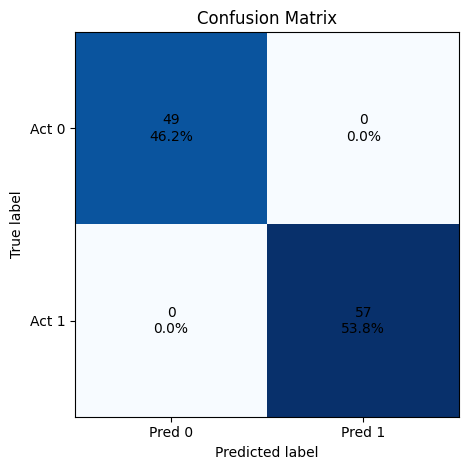

In [27]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

# 1) pull out true & predicted
y_true = validation_df['long_term_3y']
y_pred = result_df['predicted_long_term_3y']

# 2) compute raw counts
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
cm_df = pd.DataFrame(
    cm,
    index=['Actual 0','Actual 1'],
    columns=['Predicted 0','Predicted 1']
)

# 3) compute percentages
total = cm.sum()
cm_perc = cm / total * 100
cm_perc_df = pd.DataFrame(
    cm_perc,
    index=cm_df.index,
    columns=cm_df.columns
)

# 4) combine into one display
cm_display = cm_df.astype(str) + " (" + cm_perc_df.round(2).astype(str) + "%)"
print("Confusion matrix (count %):")
print(cm_display)

# — optional: matplotlib heatmap —
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    count = cm[i, j]
    pct = cm_perc[i, j]
    ax.text(j, i, f"{count}\n{pct:.1f}%", ha="center", va="center")
ax.set_xticks([0,1]); ax.set_xticklabels(['Pred 0','Pred 1'])
ax.set_yticks([0,1]); ax.set_yticklabels(['Act 0','Act 1'])
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.show()